In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import plotly.express as px
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline


In [ ]:
#importing the datasets
import pandas as pd
df = pd.read_csv (r"/content/data.csv", encoding= 'unicode_escape')
print (df)

       InvoiceNo StockCode  ... CustomerID         Country
0         536365    85123A  ...    17850.0  United Kingdom
1         536365     71053  ...    17850.0  United Kingdom
2         536365    84406B  ...    17850.0  United Kingdom
3         536365    84029G  ...    17850.0  United Kingdom
4         536365    84029E  ...    17850.0  United Kingdom
...          ...       ...  ...        ...             ...
541904    581587     22613  ...    12680.0          France
541905    581587     22899  ...    12680.0          France
541906    581587     23254  ...    12680.0          France
541907    581587     23255  ...    12680.0          France
541908    581587     22138  ...    12680.0          France

[541909 rows x 8 columns]


Removing the columns having null enteries

In [ ]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (406829, 8)


In [ ]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,object,float64,float64,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


Removing the duplicate enteries

In [ ]:
print('Duplicate enteries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Duplicate enteries: 5225


Number of Countries in the dataset

In [ ]:
tem = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
tem = tem.reset_index(drop = False)
countries = tem['Country'].value_counts()
print('Number of countries in the dataframe: {}'.format(len(countries)))

Number of countries in the dataframe: 37


In [ ]:
#plotting choromap of data
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = go.Choropleth(
    locations = countries.index,
    locationmode = 'country names', z = countries,
    text = countries.index, colorbar = {'title':'Order no.'},
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5), layout = layout)

choromap.show()


Number of products, Transactions and Customers

In [ ]:
pd.DataFrame([{'Products': len(df['StockCode'].value_counts()),    
               'Transactions': len(df['InvoiceNo'].value_counts()),
               'Customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['Products', 'Transactions', 'Customers'], index = ['Quantity'])

,Products,Transactions,Customers
Quantity,3684,22190,4372


In [ ]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
no_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
#TOP 10 products per basket according to customer id
no_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


Order Cancelled

In [ ]:
no_products_per_basket['order_canceled'] = no_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(no_products_per_basket[:10])

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0
5,12347.0,556201,18,0
6,12347.0,562032,22,0
7,12347.0,573511,47,0
8,12347.0,581180,11,0
9,12348.0,539318,17,0


In [ ]:
n1 = no_products_per_basket['order_canceled'].sum()
n2 = no_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3653/22190 (16.46%) 


In [ ]:
df_clean = df.copy(deep = True)
df_clean['QuantityCanceled'] = 0
remaining_entries = df_clean[(df_clean['Quantity'] < 0) & (df_clean['StockCode'] != 'D')]
print("Number of entries to delete: {}".format(remaining_entries.shape[0]))
#TOP 5 enteries to be deleted which were returned
print("Deleted enteries: ")
remaining_entries[:5]

Number of entries to delete: 8795
Deleted enteries: 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,0
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,0


In [ ]:
list_special_codes = df_clean[df_clean['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
#Adding total price of the basket
df_clean['TotalPrice'] = df_clean['UnitPrice'] * (df_clean['Quantity'] - df_clean['QuantityCanceled'])
#showing top 5 enteries total price of basket
df_clean.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,0,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom,0,-77183.6
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,8/2/2011 8:48,4.25,12347.0,Iceland,0,17.0
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,1/26/2011 14:30,0.55,12347.0,Iceland,0,13.2
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,12347.0,Iceland,0,15.0


Stock code

In [ ]:
list_special_codes = df_clean[df_clean['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [ ]:
for c in list_special_codes:
    print("{:<15} -> {:<30}".format(c, df_clean[df_clean['StockCode'] == c]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


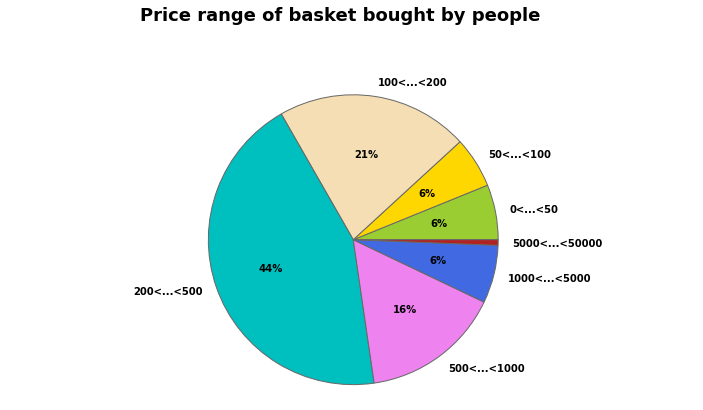

In [ ]:
temp = df_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#Representation of basket price range       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<...<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Price range of basket bought by people", ha='center', fontsize = 18);

Product Description

In [ ]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
          min_length = 1000
          for k in keywords_roots[s]:
              if len(k) < min_length:
                clef = k ; min_length = len(k)            
          category_keys.append(clef)
          keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("No. of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [ ]:
df_products = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

No. of keywords in variable 'Description': 1483


In [ ]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
liste_products.sort(key = lambda x:x[1], reverse = True)

NameError: ignored

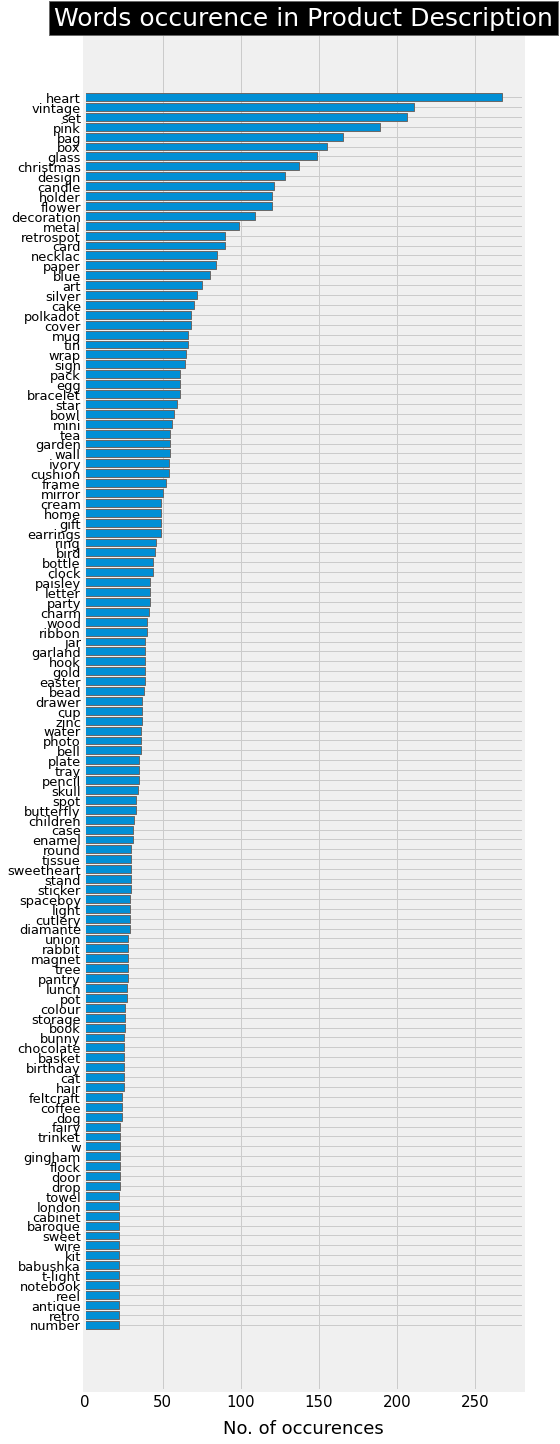

In [ ]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence in Product Description",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

Data encoding

In [ ]:
#X is a matrix which indicates words in description
liste_products = df_clean['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_products))

In [ ]:
#introducing the price range results in more balanced groups in terms of element numbers

threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_clean[ df_clean['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 12

In [ ]:
#showing the number of products in different ranges
print("{:<8} {:<23} \n".format('Range', 'No. of products') + 25*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Range    No. of products         
-------------------------
0<.<1       11580               
1<.<2       12156               
2<.<3       8088                
3<.<5       7332                
5<.<10      5712                
.>10        1884                


Forming regression model using kmean fold validation

In [ ]:
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    cluster = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, cluster)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.4857621867427438
For n_clusters = 4 The average silhouette_score is : 0.6030127905748415
For n_clusters = 5 The average silhouette_score is : 0.6995311066311025
For n_clusters = 6 The average silhouette_score is : 0.7446557315926582
For n_clusters = 7 The average silhouette_score is : 0.5688618518452133
For n_clusters = 8 The average silhouette_score is : 0.38320254727998054
For n_clusters = 9 The average silhouette_score is : 0.3857848505023193


In [ ]:
#seprating the dataset into 5 clusters to ensure best possible silhouette score
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.6995311066311025


Characterizing the content of clusters

In [ ]:
pd.Series(cluster).value_counts()

3    674
0    611
6    599
8    582
4    476
1    366
2    336
5    157
7     95
dtype: int64

In [ ]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, cluster):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        y_lower = y_upper + 10  

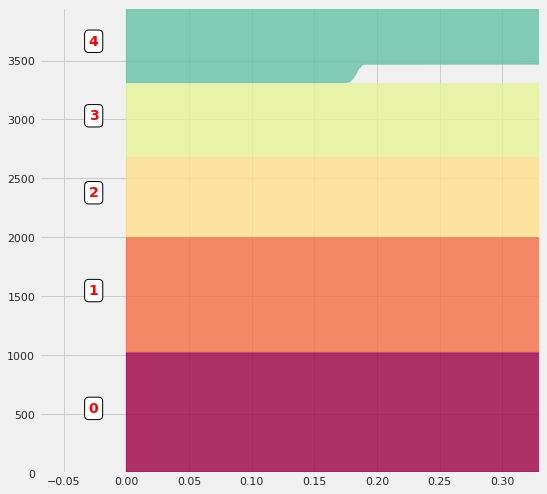

In [ ]:
silhouette_values = silhouette_samples(matrix, clusters)
# graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), silhouette_values, clusters)

Principal component analysis

In [ ]:
pca1 = PCA()
pca1.fit(matrix)
pca1_sample = pca1.transform(matrix)

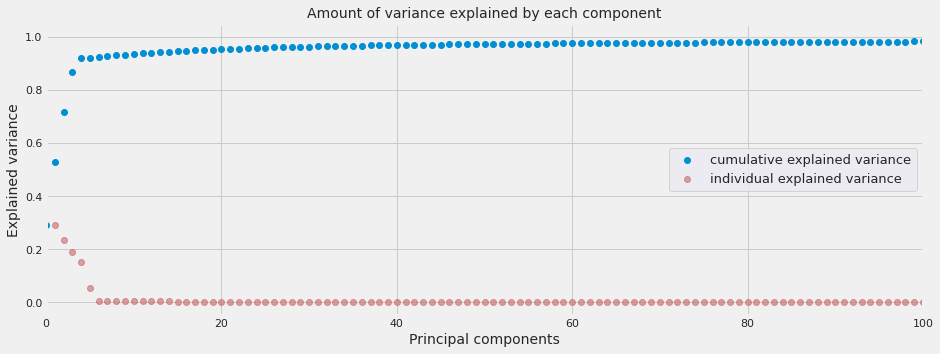

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.scatter(range(matrix.shape[1]), pca1.explained_variance_ratio_.cumsum(), 
         label='cumulative explained variance')
plt.scatter(np.arange(1,matrix.shape[1]+1), pca1.explained_variance_ratio_, alpha=0.5, color = 'r',
            label='individual explained variance')
plt.xlim(0, 100)
plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.title('Amount of variance explained by each component', fontsize =14)
plt.legend(loc='best', fontsize = 13)

In [ ]:
pca2 = PCA(n_components=50)
matrix_9D = pca2.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

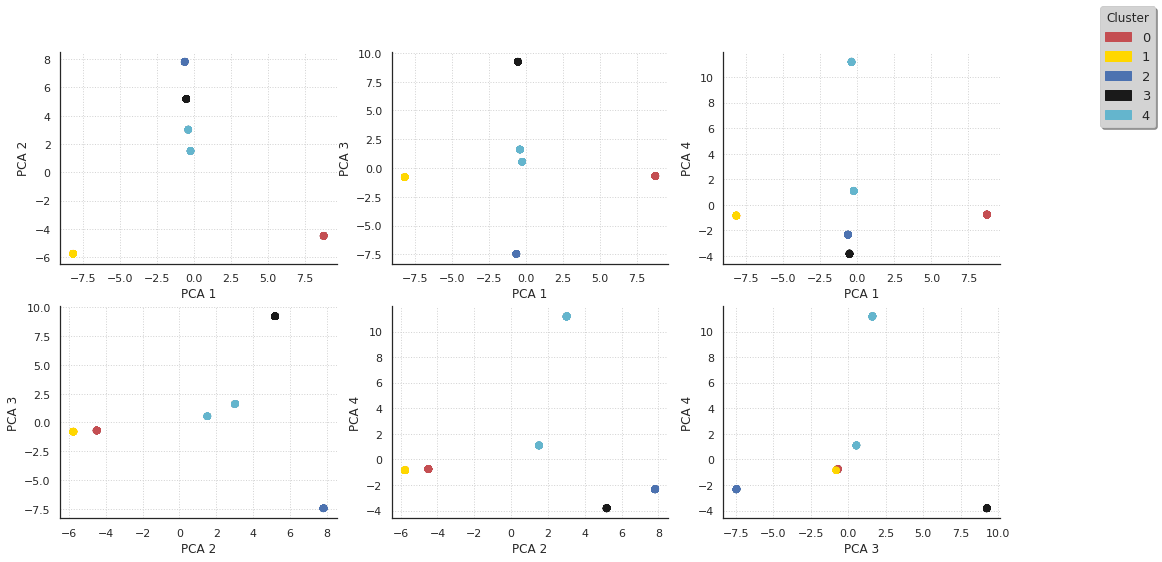

In [ ]:
#visualising data for limited number of components
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if increment == 9: break
    if increment == 9: break
        
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

Categorizing the data

In [ ]:
#Formatting the data
corresp = dict()
for key, val in zip (liste_produits, cluster):
    corresp[key] = val 
df_clean['categ_product'] = df_clean.loc[:, 'Description'].map(corresp)

In [ ]:
#Grouping the data - contains the amount spent in each product category
for i in range(5):
    col = 'Categ_{}'.format(i)        
    df_temp = df_clean[df_clean['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_clean.loc[:, col] = price_temp
    df_clean[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_clean[['InvoiceNo', 'Description', 'categ_product', 'Categ_0', 'Categ_1', 'Categ_2', 'Categ_3','Categ_4']][:5]

,InvoiceNo,Description,categ_product,Categ_0,Categ_1,Categ_2,Categ_3,Categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,3,0.00,0.0,0.0,15.3,0.0
1,536365,WHITE METAL LANTERN,0,20.34,0.0,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.0,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.0,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0,20.34,0.0,0.0,0.0,0.0


In [ ]:
temp = df_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
for i in range(5):
    col = 'Categ_{}'.format(i) 
    temp = df_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,Categ_0,Categ_1,Categ_2,Categ_3,Categ_4
0,12346.0,541431,77183.60,0.00,0.00,0.0,0.00,0.00
2,12347.0,537626,711.79,293.35,0.00,115.2,83.40,124.44
3,12347.0,542237,475.39,169.20,28.44,53.4,53.10,0.00
4,12347.0,549222,636.25,115.00,36.60,26.7,71.10,0.00
5,12347.0,556201,382.52,168.76,31.20,34.8,78.06,19.90


In [ ]:
transac_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'Categ_{}'.format(i)
    transac_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transac_per_user['sum']*100

transac_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['Categ_0'].sum()
transac_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,Categ_0,Categ_1,Categ_2,Categ_3,Categ_4
0,12346.0,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,0.000000,0.000000
1,12347.0,7,224.82,1294.32,615.714286,4310.00,29.540371,4.072390,8.109049,20.805104,7.604176
2,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,9.200775,5.808907,0.000000,0.000000
3,12349.0,1,1757.55,1757.55,1757.550000,1757.55,10.713778,1.741060,9.414241,12.245455,20.389178
4,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,0.000000,16.507177,27.900718,0.000000


In [ ]:
n1 = transac_per_user[transac_per_user['count'] == 1].shape[0]
n2 = transac_per_user.shape[0]
print("Number of clients with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

Number of clients with single purchase: 1493/4338  (34.42%)


Creation of Customer Categories

In [ ]:
#Data encoding
list_cols = ['count','min','max','mean','Categ_0','Categ_1','Categ_2','Categ_3','Categ_4']
#_____________________________________________________________
selected_customers = transac_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()

In [ ]:
scaler = StandardScaler()
scaler.fit(matrix)
print('mean values of variables: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

mean values of variables: 
------------------------------------------------------------------------------------------
 [  4.27201475 262.3719207  653.64825081 417.64573488  16.96274229
   5.47969297   7.30615273  21.52474433  14.87550433]


In [ ]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

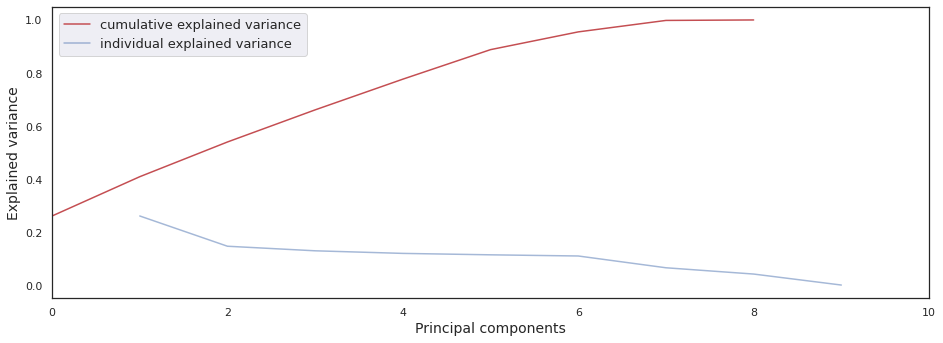

In [ ]:
#representing the amount of variance explained by each of the components
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.plot(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), 
         label='cumulative explained variance', color='r')
plt.plot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'b',
            label='individual explained variance')
plt.xlim(0, 10)

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

Creation of customer categories

In [ ]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.224


In [ ]:
#number of customers in each cluster
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['Number of clients']).T

,0,6,7,3,10,8,1,9,5,2,4
Number of clients,2203,492,438,407,353,253,148,35,7,1,1


In [ ]:
#Report via PCA
p = PCA(n_components=6)
matrix_3D = p.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

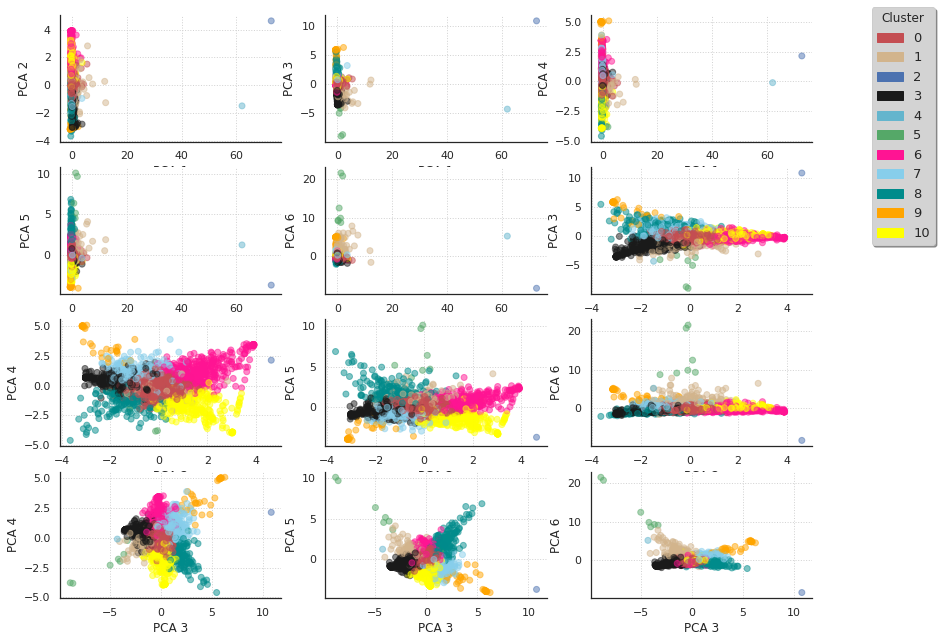

In [ ]:
#Representation of various cluster
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if increment == 12: break
    if increment == 12: break
        
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

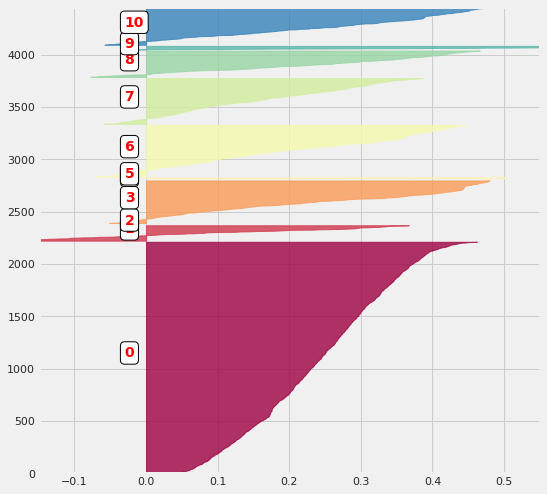

In [ ]:
#Calculating the score using silhoutte
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
# defining individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#plotting
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

In [ ]:
#Customer Morphotype
selected_customers.loc[:, 'cluster'] = clusters_clients

In [ ]:
#Deteremining number of clients in each group
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('CustomerID', axis = 1, inplace = True)
print('Number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

Number of customers: 4338


In [ ]:
#According to the total amount spent
liste_index = []
for i in range(5):
    column = 'Categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'Categ_0',
                   'Categ_1', 'Categ_2', 'Categ_3', 'Categ_4', 'size']])

IndexError: ignored

In [ ]:
#Representation of different customer morphotype
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    
    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

In [ ]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1

Classification of Customers

In [ ]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [ ]:
#Support Vector Machine Classifier (SVC)
#kfold cross validation
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)

In [ ]:
#looking at how the predictions and real values compare to the breasts of the different classes
#Confusing Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

In [ ]:
#Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
#Curves of SVC model
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

Logistic Regression

In [ ]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

In [ ]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Finding K-nearest neighbour

In [ ]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Decision Tree

In [ ]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Combining the above classifiers for the best model

In [ ]:
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [ ]:
votingC = ensemble.VotingClassifier(estimators=[('tr', tr_best),
                                                ('knn', knn_best),('lr', lr_best)], voting='soft')    

In [ ]:
votingC = votingC.fit(X_train, Y_train)

In [ ]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))